# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [3]:
# %run "Git.ipynb".ipynb

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [7]:

Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
# trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))


In [14]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [15]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [16]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15460\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [17]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [18]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()

In [19]:
holding=Binance.get_inventory()

In [20]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,2314.45,2176.11,1.00,-176.97,38.63,-138.34,-5.98
BTCUSDT,601.02,1036.77,0.48,3.54,435.75,439.29,18.98
SOLUSDT,281.20,324.54,0.15,0.00,43.34,43.34,1.87
ETHUSDT,250.75,291.23,0.13,0.00,40.48,40.48,1.75
JASMYUSDT,387.46,210.70,0.10,0.00,-176.76,-176.76,-7.64
TRXUSDT,76.87,163.62,0.08,-10.72,86.76,76.04,3.29
OMUSDT,526.32,132.43,0.06,0.00,-393.89,-393.89,-17.02
BNBUSDT,13.87,16.82,0.01,-10.61,2.95,-7.66,-0.33
BBUSDT,0.01,0.00,0.00,-84.82,-0.00,-84.82,-3.66
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.66


In [21]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

117

In [22]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [23]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [24]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [25]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [26]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [27]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [29]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 9483c3e8e54384ec9320ea124c8fb2374d97b50b)
✅ File pushed/updated successfully!


In [30]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [31]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [32]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [33]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 06318cde0cc0fa1483c062167bf1af37f51a3162)
✅ File pushed/updated successfully!


In [34]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [35]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [36]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [37]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [38]:
# pnl_history['Total']

In [39]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [40]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [41]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [42]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [43]:
pnl_history['Total']

2024-09-23   -242.846960
2024-09-24   -351.229838
2024-09-25   -362.331965
2024-09-26   -276.632747
2024-09-27   -260.113627
                 ...    
2025-08-04   -243.563212
2025-08-05   -284.583267
2025-08-06   -248.169878
2025-08-07   -179.730610
2025-08-08      4.415172
Name: Total, Length: 320, dtype: float64

<Axes: >

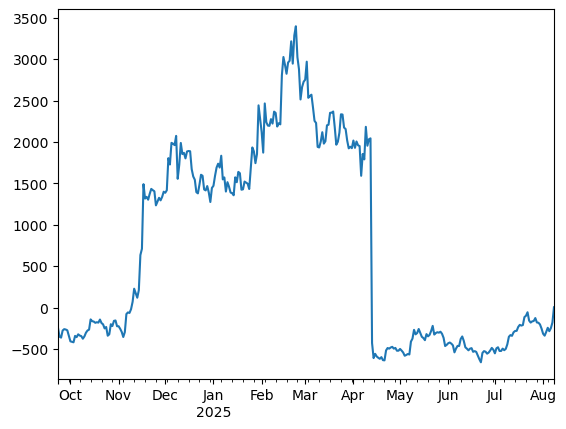

In [44]:
pnl_history['Total'].plot()

In [45]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-08-04     50.440091
2025-08-05    -41.020054
2025-08-06     36.413389
2025-08-07     68.439267
2025-08-08    184.145782
Name: Total, Length: 320, dtype: float64

In [46]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-372.021974038745, -950.5160328166933)

In [47]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [48]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [49]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [50]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [51]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [52]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [53]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

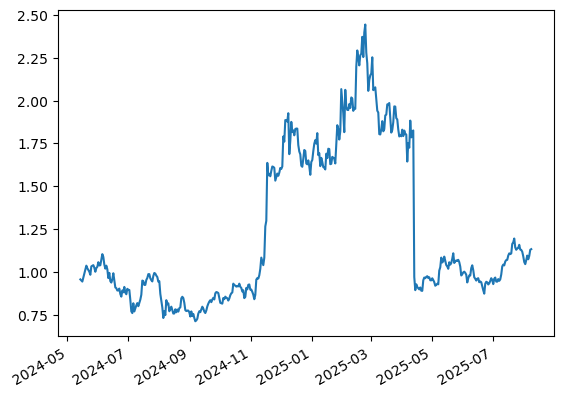

In [54]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

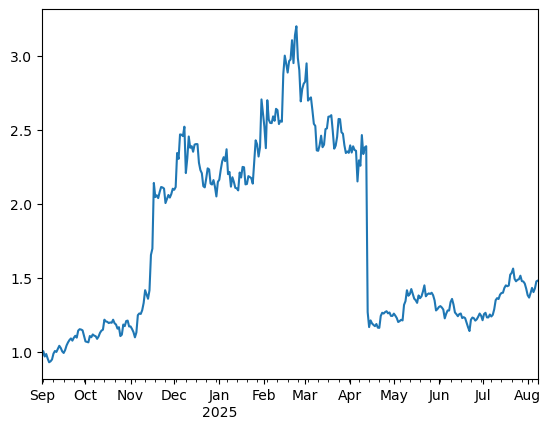

In [55]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [57]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [60]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [61]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [64]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.3647
TRXUSDT,0.1893
XRPUSDT,0.1249
ADAUSDT,0.0975
WBTCUSDT,0.0823
BTCUSDT,0.0552
OMUSDT,0.0530
PEPEUSDT,0.0184
SUIUSDT,0.0147
AVAXUSDT,0.0000


In [65]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.348956
WBTCUSDT,0.262420
TRXUSDT,0.186143
XRPUSDT,0.146078
OMUSDT,0.043575
SUIUSDT,0.012827


In [66]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

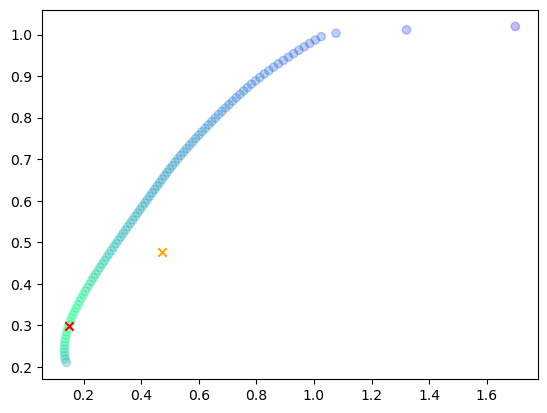

In [67]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [68]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [69]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1036.772492,4.764349e-01,0.0153,4.611349e-01
SOLUSDT,324.535716,1.491360e-01,0.0000,1.491360e-01
ETHUSDT,291.225844,1.338289e-01,0.0000,1.338289e-01
JASMYUSDT,210.699093,9.682390e-02,0.0000,9.682390e-02
TRXUSDT,163.624413,7.519140e-02,0.0245,5.069140e-02
OMUSDT,132.428450,6.085570e-02,0.0056,5.525570e-02
BNBUSDT,16.817551,7.728300e-03,0.0438,-3.607170e-02
BBUSDT,0.001629,7.000000e-07,0.0000,7.000000e-07
PEPEUSDT,0.000003,0.000000e+00,0.0056,-5.600000e-03
PAXGUSDT,0.000000,0.000000e+00,0.7626,-7.626000e-01


### Current results

In [71]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [72]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.658651
TRXUSDT,0.341349


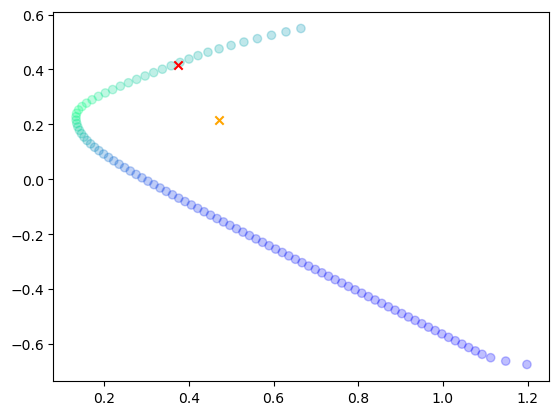

In [73]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [74]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1036.772492,4.764349e-01,0.658651,-1.822161e-01
SOLUSDT,324.535716,1.491360e-01,0.000000,1.491360e-01
ETHUSDT,291.225844,1.338289e-01,0.000000,1.338289e-01
JASMYUSDT,210.699093,9.682390e-02,0.000000,9.682390e-02
TRXUSDT,163.624413,7.519140e-02,0.341349,-2.661576e-01
OMUSDT,132.428450,6.085570e-02,0.000000,6.085570e-02
BNBUSDT,16.817551,7.728300e-03,0.000000,7.728300e-03
BBUSDT,0.001629,7.000000e-07,0.000000,7.000000e-07
PEPEUSDT,0.000003,0.000000e+00,0.000000,0.000000e+00


# Risk Reward Analysis

In [76]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [77]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

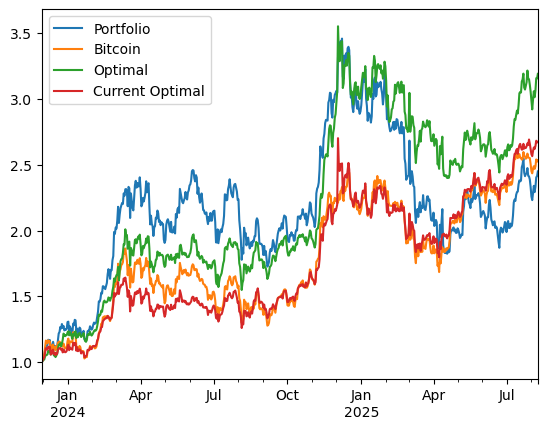

In [78]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [79]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

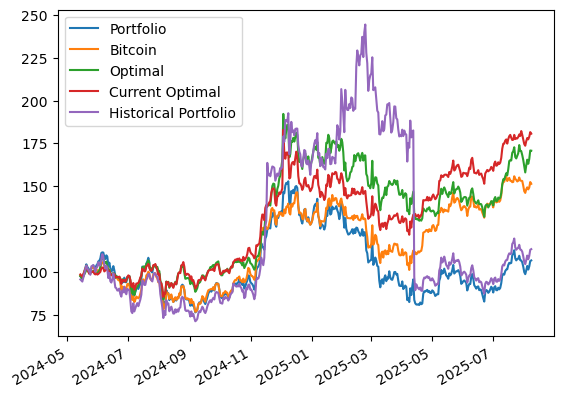

In [80]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [81]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-07-30,105.579061,153.036857,168.141790,180.012876,111.764598
2025-07-31,103.081077,150.316475,165.331346,177.453158,109.107870
2025-08-01,99.882409,147.079646,161.628846,174.637393,105.771308
2025-08-02,98.669788,146.100719,158.044920,173.631701,104.518910
2025-08-03,100.909543,148.243025,162.116514,176.294032,106.868090
2025-08-04,103.455894,149.337382,165.495100,178.117297,109.522079
2025-08-05,101.344806,148.131546,163.069731,177.352430,107.352682
2025-08-06,103.143598,149.246821,165.789146,178.863379,109.286764
2025-08-07,106.328123,152.431029,170.872644,181.575633,112.908559
2025-08-08,106.675857,151.392970,170.741252,180.651196,113.269675


## Volatilities

In [83]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.384329
 dtype: float64,
 0.3846382836324317)

In [84]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.471163
 dtype: float64,
 0.4711627306905239)

In [85]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.472613
Bitcoin            0.408467
Optimal            0.384638
Current Optimal    0.370889
dtype: float64

In [86]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.5373983882748715

In [87]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

3.5987220984437767

In [88]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.45747376371473203

## Risk Contribution

In [90]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,63.4254,0.3310,0.1605,0.1705
WBTCUSDT,40.3081,0.2211,0.0762,0.1449
XRPUSDT,30.0180,0.1848,0.0700,0.1148
TRXUSDT,23.3726,0.1638,0.0812,0.0826
SUIUSDT,1.6612,0.0180,0.0010,0.0170
OMUSDT,-48.1689,0.0813,0.0371,0.0442
Portfolio,110.6165,1.0000,0.4260,0.5740


In [91]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,41.377927,0.548189,0.465849,0.08234
TRXUSDT,31.133356,0.451811,0.369471,0.08234
Portfolio,72.511283,1.000000,0.835320,0.16468


In [92]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
test=current_risk.perf_contrib(current_weights)

# Value At Risk

## Historical

### Optimal Weights

In [96]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.0659093574240308, -0.08483148816946559)

### Current Weights

In [98]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.0814085723981901, -0.10057405322403827)

In [99]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [100]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.031255
SOLUSDT     -0.011841
ETHUSDT     -0.011170
JASMYUSDT   -0.016992
TRXUSDT     -0.003895
OMUSDT      -0.003376
BNBUSDT     -0.000664
BBUSDT      -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.079194
Name: 2025-03-09 00:00:00, dtype: float64

In [101]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.025729
SOLUSDT     -0.017941
ETHUSDT     -0.012825
JASMYUSDT   -0.013394
TRXUSDT     -0.004170
OMUSDT      -0.022330
BNBUSDT     -0.000623
BBUSDT       0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.097011
dtype: float64

## Parametric

### Optimal Weights

In [104]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.056367256291306345, -0.06981453421863075)

### Current Weights

In [106]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.06904708014224614, -0.08551932551719496)

## Multivariate

### Optimal Weights

In [109]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05439350889066814, -0.06404166902759277)

### Current Weights

In [111]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06632436499962775, -0.076810758502239)

In [112]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.023386
SOLUSDT     -0.013148
ETHUSDT     -0.010248
JASMYUSDT   -0.012369
TRXUSDT     -0.002731
OMUSDT      -0.005671
BNBUSDT     -0.000492
Portfolio   -0.068045
dtype: float64

In [113]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.023239
SOLUSDT     -0.013463
ETHUSDT     -0.010349
JASMYUSDT   -0.012327
TRXUSDT     -0.002975
OMUSDT      -0.006374
BNBUSDT     -0.000502
Portfolio   -0.069229
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [117]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05409818765248471, -0.06435113792815075)

### Current Weights

In [119]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06788065770744224, -0.0763996041932028)

In [120]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [123]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.054117088762851616, -0.06302075926857578)

### Current Weights

In [125]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06903647602578158, -0.07994344928266645)

In [126]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [129]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08031352604425063, -0.096768395076582)

### Current Weights

In [131]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.09168159623165917, -0.10762106159665308)

In [132]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [135]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [136]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05716507394136348, -0.06498233628328962)

### Current Weights

In [138]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07071988654927037, -0.07888513426710456)

In [139]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [140]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.031473,-0.023352,-0.016920,-0.023386,-0.024944
SOLUSDT,-0.007338,-0.013284,-0.008815,-0.013148,-0.013017
ETHUSDT,-0.003896,-0.009042,-0.006877,-0.010248,-0.009786
JASMYUSDT,-0.005679,-0.012089,-0.008683,-0.012369,-0.012048
TRXUSDT,-0.000928,-0.003170,-0.001979,-0.002731,-0.002252
OMUSDT,-0.009546,-0.006756,-0.006161,-0.005671,-0.007595
BNBUSDT,0.000076,-0.000441,-0.000320,-0.000492,-0.000443
Portfolio,-0.058784,-0.068134,-0.049756,-0.068045,-0.070085


In [141]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.026503,-0.023541,-0.017309,-0.023239,-0.025242
SOLUSDT,-0.010420,-0.013178,-0.009812,-0.013463,-0.012932
ETHUSDT,-0.005246,-0.009096,-0.006783,-0.010349,-0.009859
JASMYUSDT,-0.005409,-0.012589,-0.008503,-0.012327,-0.012698
TRXUSDT,-0.000916,-0.003600,-0.001178,-0.002975,-0.002443
OMUSDT,-0.011137,-0.006559,-0.006381,-0.006374,-0.007465
BNBUSDT,0.000128,-0.000446,-0.000288,-0.000502,-0.000473
Portfolio,-0.059504,-0.069009,-0.050255,-0.069229,-0.071111


## VaR Violation

In [143]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.032295,-0.040134,-0.032302,0.006968
2023-12-31,-0.032295,-0.040238,-0.033691,-0.001004
2024-01-01,-0.032295,-0.040493,-0.033841,0.017395
2024-01-02,-0.032295,-0.040432,-0.034833,0.006761
2024-01-03,-0.032295,-0.041814,-0.036681,-0.024608
...,...,...,...,...
2025-08-05,-0.029995,-0.041805,-0.037274,-0.014655
2025-08-06,-0.029995,-0.041917,-0.036755,0.016676
2025-08-07,-0.029995,-0.043287,-0.038113,0.030662
2025-08-08,-0.029995,-0.043016,-0.039175,-0.000769


In [144]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.024197,-0.077646,-0.068276,-0.016109
2024-05-29,-0.018049,-0.075586,-0.066103,-0.008965
2024-05-30,-0.018049,-0.063691,-0.058262,0.024110
2024-05-31,-0.018049,-0.062590,-0.056940,0.006482
2024-06-01,-0.018049,-0.061003,-0.056689,0.016370
...,...,...,...,...
2025-08-05,-0.040947,-0.048141,-0.054451,-0.020406
2025-08-06,-0.040947,-0.048027,-0.054892,0.017749
2025-08-07,-0.030001,-0.046449,-0.048395,0.030875
2025-08-08,-0.030001,-0.046049,-0.046284,0.003270


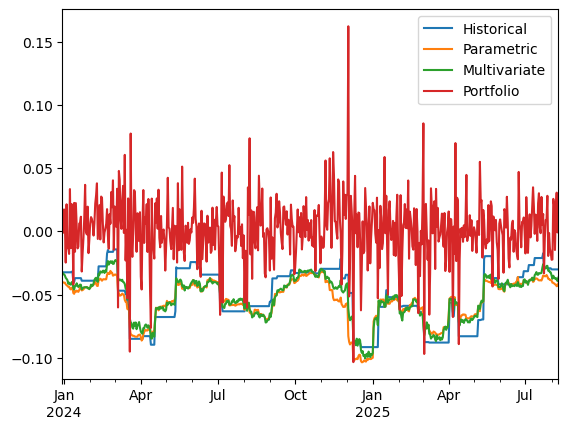

In [145]:
var_data.plot()
plt.show()

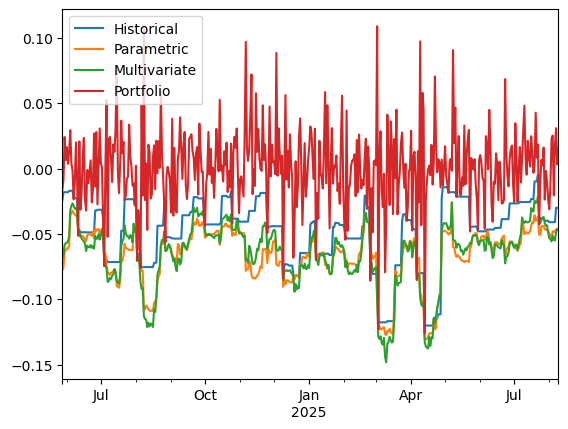

In [146]:
current_var_data.plot()
plt.show()


In [147]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.032258,0.018676,0.016978
Kupiec Stat,4.44027,15.836202,17.966207
P-value,0.035101,0.000069,0.000022


In [148]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.063781,0.018223,0.013667
Kupiec Stat,1.620686,12.21229,16.938282
P-value,0.202996,0.000475,0.000039


# Principal Component Analysis

## Historical PCA

In [151]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.58089724, 0.23236393, 0.07788184, 0.06012298, 0.04873401])

In [152]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

ADAUSDT      0.062458
AVAXUSDT     0.062550
BCHUSDT      0.047821
BNBUSDT      0.027725
BTCUSDT      0.031958
DOGEUSDT     0.065116
ETHUSDT      0.045481
HBARUSDT     0.063157
JASMYUSDT    0.072596
LINKUSDT     0.057917
LTCUSDT      0.043787
OMUSDT       0.072346
PAXGUSDT     0.000446
PEPEUSDT     0.083148
SOLUSDT      0.054887
SUIUSDT      0.060893
TRXUSDT      0.018423
USDCUSDT    -0.000163
WBTCUSDT     0.031734
XLMUSDT      0.049624
XRPUSDT      0.048098
Name: PC1, dtype: float64

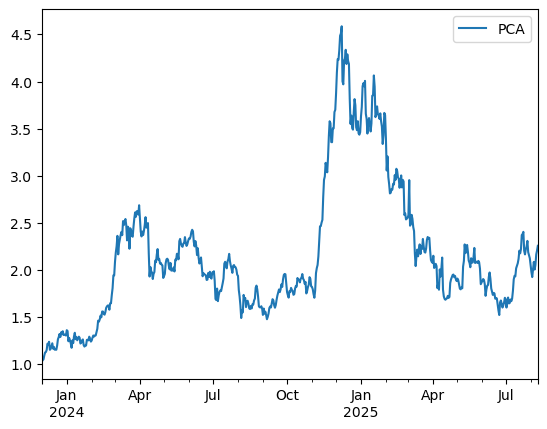

In [153]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

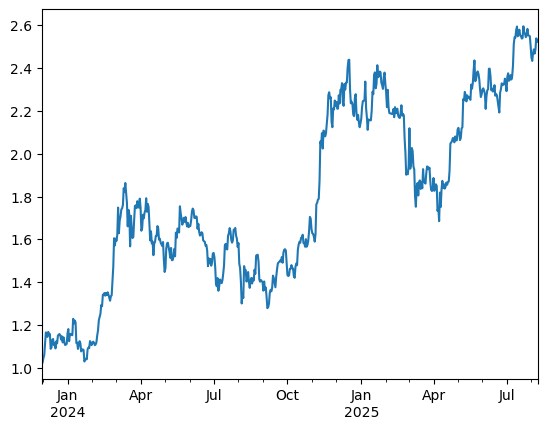

In [154]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [155]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.528283
WBTCUSDT     0.557984
BTCUSDT      0.558506
AVAXUSDT     0.670768
SOLUSDT      0.675337
LINKUSDT     0.678340
DOGEUSDT     0.695808
BNBUSDT      0.716171
LTCUSDT      0.716817
ADAUSDT      0.725455
XRPUSDT      0.767102
BCHUSDT      0.834862
XLMUSDT      0.903592
USDCUSDT     0.952747
PAXGUSDT     0.966786
SUIUSDT      1.073518
TRXUSDT      1.083650
HBARUSDT     1.100003
JASMYUSDT    1.212592
dtype: float64

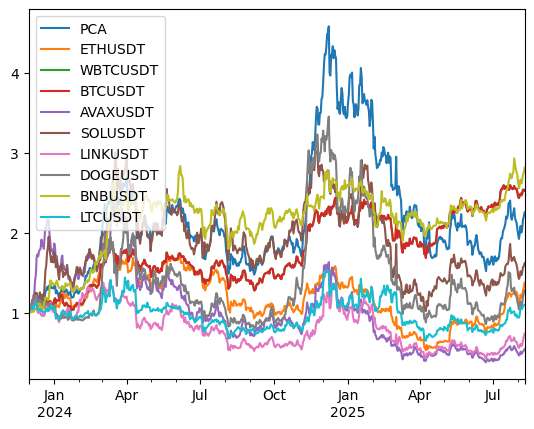

In [156]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

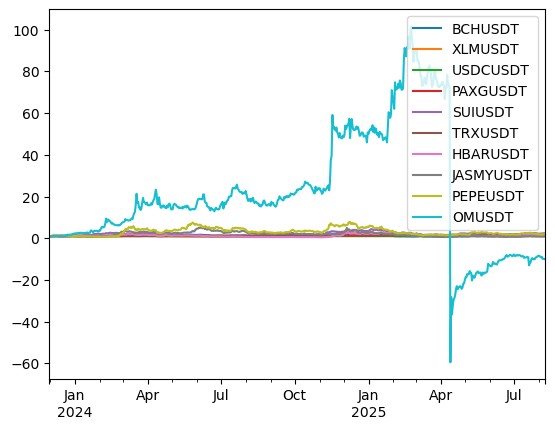

In [157]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [159]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.52254022, 0.30391116, 0.06916221, 0.06274779, 0.04163863])

In [160]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.049419
SOLUSDT      0.092298
ETHUSDT      0.080407
JASMYUSDT    0.140483
TRXUSDT      0.034503
OMUSDT       0.244454
BNBUSDT      0.051236
BBUSDT       0.169624
PEPEUSDT     0.136663
PAXGUSDT     0.000912
Name: PC1, dtype: float64

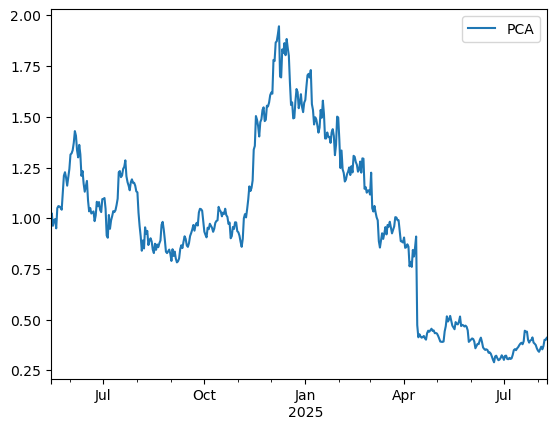

In [161]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()
plt.show()

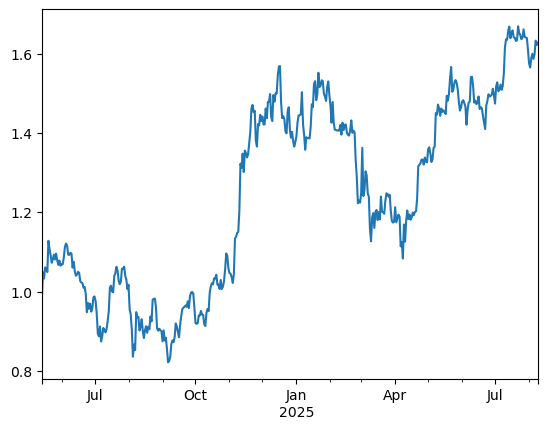

In [162]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [163]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.737275
SOLUSDT      0.775720
BTCUSDT      0.796261
BNBUSDT      0.797349
JASMYUSDT    0.978424
PEPEUSDT     1.015124
PAXGUSDT     1.056179
BBUSDT       1.080904
TRXUSDT      1.174590
dtype: float64

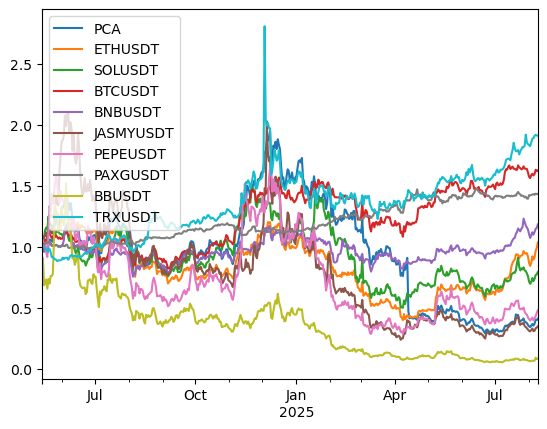

In [164]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [166]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.921542
BBUSDT       1.638460
JASMYUSDT    1.464178
SOLUSDT      1.284618
ETHUSDT      1.094373
BTCUSDT      1.000000
OMUSDT       0.988949
BNBUSDT      0.664908
TRXUSDT      0.330335
PAXGUSDT     0.027622
Name: BTCUSDT, dtype: float64

In [167]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       4.445871
JASMYUSDT    2.386606
SOLUSDT      1.849080
PEPEUSDT     1.676043
ETHUSDT      1.393730
BNBUSDT      1.201093
BTCUSDT      1.000000
OMUSDT       0.800072
TRXUSDT      0.364606
PAXGUSDT     0.084970
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [169]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [170]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.369404
JASMYUSDT,0.309791
TRXUSDT,0.164427
ETHUSDT,0.154037
PEPEUSDT,0.126280
BNBUSDT,0.104670
OMUSDT,0.063746
BBUSDT,0.032384
SOLUSDT,0.005323
PAXGUSDT,-0.091165


### Regression to PCA

In [172]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.5772360636535008

In [173]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.316106
BNBUSDT      1.126475
PCA          1.000000
ETHUSDT      0.873828
SOLUSDT      0.728228
JASMYUSDT    0.465590
PEPEUSDT     0.456764
BBUSDT       0.369615
TRXUSDT      0.284858
PAXGUSDT     0.212866
OMUSDT       0.159872
dtype: float64

In [174]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.916053
BNBUSDT      1.207807
PCA          1.000000
ETHUSDT      0.863522
SOLUSDT      0.746527
PEPEUSDT     0.716775
JASMYUSDT    0.615601
PAXGUSDT     0.609024
TRXUSDT      0.310707
BBUSDT       0.244996
OMUSDT       0.226327
dtype: float64

### Correlation Matrix

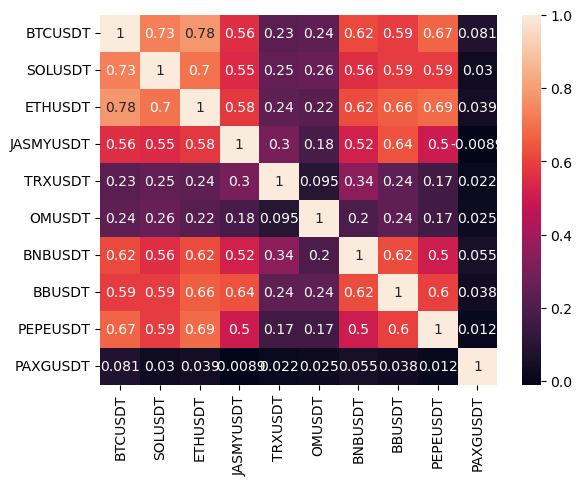

In [176]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


In [ ]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [ ]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [ ]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

In [ ]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [ ]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

In [ ]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [ ]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

In [ ]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

In [ ]:
q=rebalanced_dynamic_quantities(data[returns_to_use.columns],rolling_optimization)
ptf=q*data[returns_to_use.columns]
comparison=pd.DataFrame()
comparison['BTCUSDT']=data['BTCUSDT']
comparison['Fund']=ptf.sum(axis=1)
((1+comparison.loc['2025'].pct_change()).cumprod()*100).plot()

In [ ]:
(ptf-rebalanced_book_cost(data[returns_to_use.columns],q)).iloc[-1].sort_values(ascending=False)

In [ ]:
git.create_or_replace_notebook("Prod.ipynb")